In [10]:
import geopandas as gpd
import pandas as pd
import numpy as np
import random
import rioxarray as rxr
import xarray as xr
import pystac_client
import planetary_computer as pc
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings
import os
from pathlib import Path

In [34]:

# setup: Ensure correct working directory
print("Setting up working directory...")

current_dir = Path.cwd()
target_dir = None

# check if we're already in the right place
if current_dir.name == "scripts" and current_dir.parent.name == "CHAR":
    print(f"Already in correct directory: {current_dir}")
    target_dir = current_dir
else:
    # Find CHAR directory
    for check_dir in [current_dir, current_dir / "CHAR"] + [p / "CHAR" for p in current_dir.parents]:
        if check_dir.name == "CHAR" and check_dir.exists():
            scripts_path = check_dir / "scripts"
            if scripts_path.exists():
                os.chdir(scripts_path)
                target_dir = scripts_path
                print(f"✓ Changed to: {scripts_path}")
                break
    
    if target_dir is None:
        print("Could not find CHAR/scripts directory")
        print("Please make sure you're running this from within a CHAR project directory")
        raise FileNotFoundError("CHAR/scripts directory not found")

# Verify we can access the data
data_path = Path("../downloaded_data/mnf_fires_all.geojson")
if not data_path.exists():
    print(f"Cannot find fire data at: {data_path.resolve()}")
    print("Please check your directory structure")
else:
    print(f"Found fire data at: {data_path.resolve()}")

# Load the data
#fires = gpd.read_file("../downloaded_data/mnf_fires_all.geojson")

Setting up working directory...
Already in correct directory: /home/jovyan/CHAR/scripts
Found fire data at: /home/jovyan/CHAR/downloaded_data/mnf_fires_all.geojson


In [3]:
#!pip install stackstac --quiet

In [12]:
fires = gpd.read_file("../downloaded_data/mnf_fires_all.geojson")

# Step-by-step fix that handles any data type issues
print("Fixing FIRE_YEAR column...")

# Method 1: Convert each value individually
def safe_year_conversion(value):
    """Safely convert any value to integer year"""
    try:
        if pd.isna(value):
            return None
        # Handle string dates like "2020-01-01" -> 2020
        if isinstance(value, str) and '-' in value:
            return int(value.split('-')[0])
        # Handle floats like 2020.0 -> 2020
        return int(float(value))
    except:
        print(f"Could not convert value: {value} (type: {type(value)})")
        return None

# Apply the safe conversion
fires['FIRE_YEAR_CLEAN'] = fires['FIRE_YEAR'].apply(safe_year_conversion)

# Remove rows where conversion failed
initial_count = len(fires)
fires = fires.dropna(subset=['FIRE_YEAR_CLEAN'])
print(f"Kept {len(fires)} out of {initial_count} fires")

# Now use the clean column for date creation
fires['FIRE_YEAR_CLEAN'] = fires['FIRE_YEAR_CLEAN'].astype(int)

# Create dates using string formatting (this avoids the addition problem)
fires['pre_fire_date'] = fires['FIRE_YEAR_CLEAN'].apply(lambda x: pd.to_datetime(f"{x}-04-15"))
fires['post_fire_1yr'] = fires['FIRE_YEAR_CLEAN'].apply(lambda x: pd.to_datetime(f"{x+1}-07-01"))
fires['post_fire_2yr'] = fires['FIRE_YEAR_CLEAN'].apply(lambda x: pd.to_datetime(f"{x+2}-07-01"))
fires['post_fire_5yr'] = fires['FIRE_YEAR_CLEAN'].apply(lambda x: pd.to_datetime(f"{x+5}-07-01"))

print("✓ Dates created successfully!")
print(f"Sample dates for first fire:")
sample = fires.iloc[0]
print(f"  Fire year: {sample['FIRE_YEAR_CLEAN']}")
print(f"  Pre-fire: {sample['pre_fire_date']}")
print(f"  1yr post: {sample['post_fire_1yr']}")

Fixing FIRE_YEAR column...
Kept 216 out of 216 fires
✓ Dates created successfully!
Sample dates for first fire:
  Fire year: 1910
  Pre-fire: 1910-04-15 00:00:00
  1yr post: 1911-07-01 00:00:00


In [16]:
"""
Fire Severity Analysis using Landsat 5 NBR

This module analyzes wildfire burn severity using Normalized Burn Ratio (NBR) 
calculated from Landsat 5 satellite imagery.

Functions:
- clean_fire_year(): Converts fire year values to integers, handling various formats
- search_landsat5_imagery(): Searches for Landsat 5 images around a target date (polygon-based)
- search_with_expanding_dates(): Searches with progressively wider date ranges (max 60 days)
- calculate_nbr(): Computes NBR from Landsat 5 NIR and SWIR2 bands
- analyze_burn_severity(): Classifies burn severity from dNBR values
- run_fire_analysis(): Main workflow to analyze a single fire

Usage:
    run_fire_analysis(target_year=1989)
"""

import geopandas as gpd
import pandas as pd
import numpy as np
import rioxarray as rxr
import pystac_client
import planetary_computer as pc
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


def clean_fire_year(year_value):
    """Convert fire year to integer, handling strings and numbers."""
    try:
        if pd.isna(year_value):
            return None
        year_str = str(year_value)
        if '-' in year_str:
            return int(year_str.split('-')[0])
        return int(float(year_str))
    except (ValueError, TypeError):
        return None


def search_landsat5_imagery(geometry, target_date, days_buffer=30):
    """Search for Landsat 5 imagery around target date using polygon geometry."""
    start_date = (target_date - timedelta(days=days_buffer)).strftime('%Y-%m-%d')
    end_date = (target_date + timedelta(days=days_buffer)).strftime('%Y-%m-%d')
    
    print(f"Searching Landsat 5 imagery from {start_date} to {end_date}")
    
    catalog = pystac_client.Client.open(
        "https://planetarycomputer.microsoft.com/api/stac/v1/",
        modifier=pc.sign_inplace
    )
    
    # Use geometry directly instead of bounding box
    geometry_dict = geometry.__geo_interface__
    
    # First try with low cloud cover
    search = catalog.search(
        collections=["landsat-c2-l2"],
        intersects=geometry_dict,
        datetime=f"{start_date}/{end_date}",
        query={
            "platform": {"in": ["landsat-5"]},
            "eo:cloud_cover": {"lt": 20}  # Stricter cloud filter
        }
    )
    
    items = list(search.items())
    
    if len(items) == 0:
        print("No images found with <20% clouds, trying <50%...")
        search = catalog.search(
            collections=["landsat-c2-l2"],
            intersects=geometry_dict,
            datetime=f"{start_date}/{end_date}",
            query={
                "platform": {"in": ["landsat-5"]},
                "eo:cloud_cover": {"lt": 50}
            }
        )
        items = list(search.items())
    
    if len(items) == 0:
        print("No images found with cloud filter, trying without...")
        search = catalog.search(
            collections=["landsat-c2-l2"],
            intersects=geometry_dict,
            datetime=f"{start_date}/{end_date}",
            query={"platform": {"in": ["landsat-5"]}}
        )
        items = list(search.items())
    
    if len(items) > 0:
        items_with_info = []
        for item in items:
            cloud_cover = item.properties.get('eo:cloud_cover', 100)
            item_date = pd.to_datetime(item.properties['datetime'])
            
            if item_date.tz is not None:
                item_date = item_date.tz_localize(None)
            if hasattr(target_date, 'tz') and target_date.tz is not None:
                target_date = target_date.tz_localize(None)
            
            date_diff = abs((item_date - target_date).days)
            items_with_info.append((item, cloud_cover, date_diff, item_date.strftime('%Y-%m-%d')))
        
        items_with_info.sort(key=lambda x: (x[2], x[1]))  # Sort by date proximity, then cloud cover
        sorted_items = [item for item, cloud, date_diff, date_str in items_with_info]
        
        print(f"Found {len(sorted_items)} Landsat 5 images:")
        for i, (item, cloud, date_diff, date_str) in enumerate(items_with_info):
            print(f"  Image {i+1}: {date_str}, {cloud:.1f}% clouds, {date_diff} days from target")
        
        return sorted_items
    else:
        print("No Landsat 5 images found")
        return []


def search_with_expanding_dates(geometry, target_date):
    """Search with progressively expanding date ranges (max 60 days)."""
    buffers = [30, 60]  # Only search up to 60 days
    
    for attempt, buffer in enumerate(buffers):
        print(f"Attempt {attempt + 1}: Searching with +/-{buffer} day buffer...")
        items = search_landsat5_imagery(geometry, target_date, days_buffer=buffer)
        
        if len(items) > 0:
            return items
            
        if attempt < len(buffers) - 1:
            print("No results, expanding search window...")
    
    print("No Landsat 5 imagery found within 60 days")
    return []


def calculate_nbr(item, fire_polygon):
    """Calculate NBR from Landsat 5 data, clipped to fire boundary."""
    try:
        signed_item = pc.sign(item)
        
        print(f"Processing image from: {item.properties.get('datetime', 'Unknown')}")
        print(f"Cloud cover: {item.properties.get('eo:cloud_cover', 'Unknown')}%")
        
        # Find NIR and SWIR2 bands
        nir_band = None
        swir2_band = None
        
        for asset_name in signed_item.assets.keys():
            if asset_name in ['B04', 'nir08']:
                nir_band = asset_name
            elif asset_name in ['B07', 'swir22']:
                swir2_band = asset_name
        
        if nir_band is None or swir2_band is None:
            print(f"Could not find required bands. NIR: {nir_band}, SWIR2: {swir2_band}")
            return None
        
        print(f"Using NIR band: {nir_band}, SWIR2 band: {swir2_band}")
        
        # Load bands
        nir = rxr.open_rasterio(signed_item.assets[nir_band].href, chunks={'x': 1024, 'y': 1024})
        swir2 = rxr.open_rasterio(signed_item.assets[swir2_band].href, chunks={'x': 1024, 'y': 1024})
        
        # Convert fire polygon to raster CRS
        temp_gdf = gpd.GeoDataFrame([1], geometry=[fire_polygon], crs='EPSG:4326')
        fire_proj = temp_gdf.to_crs(nir.rio.crs).geometry.iloc[0]
        
        # Create a buffered version for initial crop (more efficient than loading full scene)
        fire_buffered = fire_proj.buffer(2000)  # 2km buffer around fire
        
        try:
            # Crop to buffered fire area first (for efficiency)
            nir_cropped = nir.rio.clip([fire_buffered], crs=nir.rio.crs, drop=True)
            swir2_cropped = swir2.rio.clip([fire_buffered], crs=swir2.rio.crs, drop=True)
            print(f"Cropped to fire area: NIR {nir_cropped.shape}, SWIR2 {swir2_cropped.shape}")
        except:
            print("Polygon cropping failed, using original extent")
            nir_cropped = nir
            swir2_cropped = swir2
        
        # Apply Landsat Collection 2 scaling
        nir_scaled = nir_cropped * 0.0000275 - 0.2
        swir2_scaled = swir2_cropped * 0.0000275 - 0.2
        
        # Ensure same resolution
        if nir_scaled.shape != swir2_scaled.shape:
            swir2_scaled = swir2_scaled.rio.reproject_match(nir_scaled)
        
        # Calculate NBR
        nbr = (nir_scaled - swir2_scaled) / (nir_scaled + swir2_scaled)
        nbr = nbr.where((nir_scaled + swir2_scaled) != 0)
        
        # Final clip to exact fire boundary
        nbr_fire_only = nbr.rio.clip([fire_proj], crs=nbr.rio.crs, drop=True, all_touched=True)
        
        # Check results
        valid_pixels = (~np.isnan(nbr_fire_only.values)).sum()
        total_pixels = nbr_fire_only.size
        
        print(f"Valid pixels: {valid_pixels}/{total_pixels} ({100*valid_pixels/total_pixels:.1f}%)")
        
        if valid_pixels == 0:
            print("No valid data within fire boundary")
            return None
        
        print("NBR calculated successfully")
        return nbr_fire_only
        
    except Exception as e:
        print(f"Error calculating NBR: {e}")
        return None


def analyze_burn_severity(dnbr_values):
    """Classify burn severity from dNBR values."""
    high_severity = np.sum(dnbr_values > 0.66)
    mod_high_severity = np.sum((dnbr_values >= 0.44) & (dnbr_values <= 0.66))
    mod_low_severity = np.sum((dnbr_values >= 0.25) & (dnbr_values < 0.44))
    low_severity = np.sum((dnbr_values >= 0.1) & (dnbr_values < 0.25))
    unburned = np.sum(dnbr_values < 0.1)
    total_pixels = len(dnbr_values)
    
    return {
        'high_severity': high_severity,
        'mod_high_severity': mod_high_severity,
        'mod_low_severity': mod_low_severity,
        'low_severity': low_severity,
        'unburned': unburned,
        'total_pixels': total_pixels
    }


def run_fire_analysis_by_date(fire_name, fire_date, geojson_path="../downloaded_data/mnf_fires_all.geojson", 
                              pre_fire_days=30, post_fire_days=365):
    """
    Analyze fire burn severity using actual fire date.
    
    Parameters:
    - fire_name: Name of the fire to search for
    - fire_date: Date when fire was contained/detected (e.g., "1989-08-04")
    - pre_fire_days: Days before fire_date to search for pre-fire imagery (default 30)
    - post_fire_days: Days after fire_date to search for post-fire imagery (default 365)
    """
    print(f"Loading fire data to find '{fire_name}'...")
    fires = gpd.read_file(geojson_path)
    
    # Clean fire year data
    fires['FIRE_YEAR_CLEAN'] = fires['FIRE_YEAR'].apply(clean_fire_year)
    fires_clean = fires.dropna(subset=['FIRE_YEAR_CLEAN'])
    fires_clean['FIRE_YEAR_CLEAN'] = fires_clean['FIRE_YEAR_CLEAN'].astype(int)
    fires_wgs84 = fires_clean.to_crs('EPSG:4326')
    
    # Search for fire by name
    fire_matches = fires_wgs84[
        fires_wgs84['INCIDENT'].str.contains(fire_name, case=False, na=False)
    ]
    
    if len(fire_matches) == 0:
        print(f"No fires found matching '{fire_name}'")
        print("Available fire names (sample):")
        sample_names = fires_wgs84['INCIDENT'].dropna().head(10).tolist()
        for name in sample_names:
            print(f"  - {name}")
        return None
    
    if len(fire_matches) > 1:
        print(f"Found {len(fire_matches)} fires matching '{fire_name}':")
        for i, (idx, fire) in enumerate(fire_matches.iterrows()):
            year = int(fire['FIRE_YEAR_CLEAN'])
            fire_id = fire.get('UNQE_FIRE_', 'No ID')
            area = fire.geometry.area * 111 * 111 * 100  # rough hectares
            print(f"  {i}: {fire['INCIDENT']} ({year}) - {area:.1f} ha - {fire_id}")
        
        # Use the first match
        selected_fire = fire_matches.iloc[0]
        print(f"Using: {selected_fire['INCIDENT']} ({int(selected_fire['FIRE_YEAR_CLEAN'])})")
    else:
        selected_fire = fire_matches.iloc[0]
        print(f"Found: {selected_fire['INCIDENT']} ({int(selected_fire['FIRE_YEAR_CLEAN'])})")
    
    # Extract fire info
    fire_geom = selected_fire.geometry
    fire_id = selected_fire.get("UNQE_FIRE_", "unknown")
    incident = selected_fire.get("INCIDENT", "unknown")
    fire_year = int(selected_fire["FIRE_YEAR_CLEAN"])
    
    print(f"\nSelected Fire: {incident} ({fire_id})")
    print(f"Fire Year: {fire_year}")
    print(f"Fire Area: {fire_geom.area:.8f} square degrees")
    
    # Parse fire date and calculate analysis dates
    fire_date_parsed = pd.to_datetime(fire_date)
    pre_fire_date = fire_date_parsed - timedelta(days=pre_fire_days)
    post_fire_date = fire_date_parsed + timedelta(days=post_fire_days)
    
    print(f"\nAnalysis Timeline:")
    print(f"Fire date (contained): {fire_date_parsed.strftime('%Y-%m-%d')}")
    print(f"Pre-fire target: {pre_fire_date.strftime('%Y-%m-%d')} ({pre_fire_days} days before)")
    print(f"Post-fire target: {post_fire_date.strftime('%Y-%m-%d')} ({post_fire_days} days after)")
    
    # Search for pre-fire imagery
    print(f"\n1. Searching for pre-fire imagery...")
    pre_fire_items = search_with_expanding_dates(fire_geom, pre_fire_date)
    
    if len(pre_fire_items) == 0:
        print("No pre-fire imagery found")
        return None
    
    # Calculate pre-fire NBR
    print(f"\n2. Calculating pre-fire NBR...")
    pre_fire_nbr = calculate_nbr(pre_fire_items[0], fire_geom)
    
    if pre_fire_nbr is None:
        print("Failed to calculate pre-fire NBR")
        return None
    
    pre_stats = pre_fire_nbr.compute()
    print(f"Pre-fire NBR: Mean {float(pre_stats.mean().values):.3f}")
    
    # Search for post-fire imagery
    print(f"\n3. Searching for post-fire imagery...")
    post_fire_items = search_with_expanding_dates(fire_geom, post_fire_date)
    
    if len(post_fire_items) == 0:
        print("No post-fire imagery found")
        return None
    
    # Calculate post-fire NBR
    print(f"\n4. Calculating post-fire NBR...")
    post_fire_nbr = calculate_nbr(post_fire_items[0], fire_geom)
    
    if post_fire_nbr is None:
        print("Failed to calculate post-fire NBR")
        return None
    
    post_stats = post_fire_nbr.compute()
    print(f"Post-fire NBR: Mean {float(post_stats.mean().values):.3f}")
    
    # Calculate dNBR
    print(f"\n5. Calculating dNBR...")
    
    if pre_fire_nbr.rio.crs != post_fire_nbr.rio.crs:
        post_fire_nbr = post_fire_nbr.rio.reproject_match(pre_fire_nbr)
    
    dnbr = pre_fire_nbr - post_fire_nbr
    dnbr_computed = dnbr.compute()
    dnbr_flat = dnbr_computed.values.flatten()
    dnbr_flat = dnbr_flat[~np.isnan(dnbr_flat)]
    
    if len(dnbr_flat) == 0:
        print("No valid dNBR values calculated")
        return None
    
    # Analyze burn severity
    severity_results = analyze_burn_severity(dnbr_flat)
    
    # Display results
    print(f"\nLANDSAT 5 ANALYSIS RESULTS")
    print(f"Fire: {incident} ({fire_id}), Year: {fire_year}")
    print(f"Fire Date: {fire_date_parsed.strftime('%Y-%m-%d')}")
    print(f"Satellite: Landsat 5 (30m resolution)")
    
    print(f"\nNBR Statistics (Fire Boundary Only):")
    print(f"Pre-fire NBR  - Mean: {float(pre_stats.mean().values):.3f}")
    print(f"Post-fire NBR - Mean: {float(post_stats.mean().values):.3f}")
    print(f"dNBR          - Mean: {np.mean(dnbr_flat):.3f}, Range: {np.min(dnbr_flat):.3f} to {np.max(dnbr_flat):.3f}")
    
    total = severity_results['total_pixels']
    print(f"\nBurn Severity Classification ({total} pixels):")
    print(f"High Severity (>0.66):      {severity_results['high_severity']:5d} pixels ({100*severity_results['high_severity']/total:5.1f}%)")
    print(f"Moderate-High (0.44-0.66):  {severity_results['mod_high_severity']:5d} pixels ({100*severity_results['mod_high_severity']/total:5.1f}%)")
    print(f"Moderate-Low (0.25-0.44):   {severity_results['mod_low_severity']:5d} pixels ({100*severity_results['mod_low_severity']/total:5.1f}%)")
    print(f"Low Severity (0.1-0.25):    {severity_results['low_severity']:5d} pixels ({100*severity_results['low_severity']/total:5.1f}%)")
    print(f"Unburned (<0.1):            {severity_results['unburned']:5d} pixels ({100*severity_results['unburned']/total:5.1f}%)")
    
    print(f"\nAnalysis complete!")
    
    # Create visualization
    try:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        pre_geo = pre_fire_nbr.rio.reproject('EPSG:4326')
        post_geo = post_fire_nbr.rio.reproject('EPSG:4326')
        dnbr_geo = dnbr.rio.reproject('EPSG:4326')
        
        pre_geo.plot(ax=axes[0], cmap='RdYlGn', vmin=-0.5, vmax=1.0)
        post_geo.plot(ax=axes[1], cmap='RdYlGn', vmin=-0.5, vmax=1.0)
        dnbr_geo.plot(ax=axes[2], cmap='RdBu_r', vmin=0, vmax=1.0)
        
        axes[0].set_title(f'Pre-fire NBR\n{pre_fire_date.strftime("%Y-%m-%d")}')
        axes[1].set_title(f'Post-fire NBR\n{post_fire_date.strftime("%Y-%m-%d")}')
        axes[2].set_title('dNBR (Burn Severity)')
        
        plt.suptitle(f'{incident} Fire ({fire_date_parsed.strftime("%Y-%m-%d")}) - Landsat 5 Analysis')
        plt.tight_layout()
        plt.show()
        
    except Exception as plot_error:
        print(f"Plotting failed: {plot_error}")
    
    return {
        'fire_info': {
            'name': incident,
            'id': fire_id,
            'year': fire_year,
            'fire_date': fire_date_parsed,
            'geometry': fire_geom
        },
        'analysis_dates': {
            'pre_fire': pre_fire_date,
            'post_fire': post_fire_date
        },
        'severity_results': severity_results,
        'dnbr_stats': {
            'mean': np.mean(dnbr_flat),
            'std': np.std(dnbr_flat),
            'min': np.min(dnbr_flat),
            'max': np.max(dnbr_flat)
        },
        'pre_fire_nbr': pre_fire_nbr,
        'post_fire_nbr': post_fire_nbr,
        'dnbr': dnbr
    }
    """Main workflow to analyze fire burn severity for a specific year."""
    print(f"Loading fire data for {target_year}...")
    fires = gpd.read_file(geojson_path)
    
    # Clean fire year data
    fires['FIRE_YEAR_CLEAN'] = fires['FIRE_YEAR'].apply(clean_fire_year)
    fires_clean = fires.dropna(subset=['FIRE_YEAR_CLEAN'])
    fires_clean['FIRE_YEAR_CLEAN'] = fires_clean['FIRE_YEAR_CLEAN'].astype(int)
    
    print(f"Available years: {sorted(fires_clean['FIRE_YEAR_CLEAN'].unique())}")
    
    # Filter for target year
    target_fires = fires_clean[fires_clean['FIRE_YEAR_CLEAN'] == target_year].copy()
    print(f"Found {len(target_fires)} fires from {target_year}")
    
    if len(target_fires) == 0:
        print(f"No fires found for {target_year}. Trying nearby years...")
        for test_year in [target_year-1, target_year+1, target_year-2, target_year+2]:
            test_fires = fires_clean[fires_clean['FIRE_YEAR_CLEAN'] == test_year]
            if len(test_fires) > 0:
                print(f"Using {test_year} fires for testing ({len(test_fires)} fires)")
                target_fires = test_fires.copy()
                target_year = test_year
                break
    
    if len(target_fires) == 0:
        print(f"No fires found near year {target_year}")
        return
    
    # Select first fire and convert to WGS84
    target_fires_wgs84 = target_fires.to_crs('EPSG:4326')
    test_fire = target_fires_wgs84.iloc[0]
    fire_geom = test_fire.geometry
    fire_id = test_fire.get("UNQE_FIRE_", "unknown")
    incident = test_fire.get("INCIDENT", "unknown")
    fire_year = int(test_fire["FIRE_YEAR_CLEAN"])
    
    print(f"\nSelected Fire: {incident} ({fire_id})")
    print(f"Fire Year: {fire_year}")
    print(f"Fire Area: {fire_geom.area:.8f} square degrees")
    
    # Define analysis dates
    pre_fire_date = pd.to_datetime(f"{fire_year}-04-15")
    post_fire_1yr = pd.to_datetime(f"{fire_year + 1}-07-01")
    
    print(f"\nAnalysis Timeline:")
    print(f"Pre-fire (baseline): {pre_fire_date.strftime('%Y-%m-%d')}")
    print(f"1 year post-fire: {post_fire_1yr.strftime('%Y-%m-%d')}")
    
    # Search for pre-fire imagery
    print(f"\n1. Searching for pre-fire imagery...")
    pre_fire_items = search_with_expanding_dates(fire_geom, pre_fire_date)
    
    if len(pre_fire_items) == 0:
        print("No pre-fire imagery found")
        return
    
    # Calculate pre-fire NBR
    print(f"\n2. Calculating pre-fire NBR...")
    pre_fire_nbr = calculate_nbr(pre_fire_items[0], fire_geom)
    
    if pre_fire_nbr is None:
        print("Failed to calculate pre-fire NBR")
        return
    
    pre_stats = pre_fire_nbr.compute()
    print(f"Pre-fire NBR: Mean {float(pre_stats.mean().values):.3f}")
    
    # Search for post-fire imagery
    print(f"\n3. Searching for post-fire imagery...")
    post_fire_items = search_with_expanding_dates(fire_geom, post_fire_1yr)
    
    if len(post_fire_items) == 0:
        print("No post-fire imagery found")
        return
    
    # Calculate post-fire NBR
    print(f"\n4. Calculating post-fire NBR...")
    post_fire_nbr = calculate_nbr(post_fire_items[0], fire_geom)
    
    if post_fire_nbr is None:
        print("Failed to calculate post-fire NBR")
        return
    
    post_stats = post_fire_nbr.compute()
    print(f"Post-fire NBR: Mean {float(post_stats.mean().values):.3f}")
    
    # Calculate dNBR
    print(f"\n5. Calculating dNBR...")
    
    if pre_fire_nbr.rio.crs != post_fire_nbr.rio.crs:
        post_fire_nbr = post_fire_nbr.rio.reproject_match(pre_fire_nbr)
    
    dnbr = pre_fire_nbr - post_fire_nbr
    dnbr_computed = dnbr.compute()
    dnbr_flat = dnbr_computed.values.flatten()
    dnbr_flat = dnbr_flat[~np.isnan(dnbr_flat)]
    
    if len(dnbr_flat) == 0:
        print("No valid dNBR values calculated")
        return
    
    # Analyze burn severity
    severity_results = analyze_burn_severity(dnbr_flat)
    
    # Display results
    print(f"\nLANDSAT 5 ANALYSIS RESULTS")
    print(f"Fire: {incident} ({fire_id}), Year: {fire_year}")
    print(f"Satellite: Landsat 5 (30m resolution)")
    print(f"Analysis Period: {pre_fire_date.strftime('%Y-%m-%d')} to {post_fire_1yr.strftime('%Y-%m-%d')}")
    
    print(f"\nNBR Statistics (Fire Boundary Only):")
    print(f"Pre-fire NBR  - Mean: {float(pre_stats.mean().values):.3f}")
    print(f"Post-fire NBR - Mean: {float(post_stats.mean().values):.3f}")
    print(f"dNBR          - Mean: {np.mean(dnbr_flat):.3f}, Range: {np.min(dnbr_flat):.3f} to {np.max(dnbr_flat):.3f}")
    
    total = severity_results['total_pixels']
    print(f"\nBurn Severity Classification ({total} pixels):")
    print(f"High Severity (>0.66):      {severity_results['high_severity']:5d} pixels ({100*severity_results['high_severity']/total:5.1f}%)")
    print(f"Moderate-High (0.44-0.66):  {severity_results['mod_high_severity']:5d} pixels ({100*severity_results['mod_high_severity']/total:5.1f}%)")
    print(f"Moderate-Low (0.25-0.44):   {severity_results['mod_low_severity']:5d} pixels ({100*severity_results['mod_low_severity']/total:5.1f}%)")
    print(f"Low Severity (0.1-0.25):    {severity_results['low_severity']:5d} pixels ({100*severity_results['low_severity']/total:5.1f}%)")
    print(f"Unburned (<0.1):            {severity_results['unburned']:5d} pixels ({100*severity_results['unburned']/total:5.1f}%)")
    
    print(f"\nAnalysis complete for {fire_year} fire!")
    
    # Create visualization
    try:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        pre_geo = pre_fire_nbr.rio.reproject('EPSG:4326')
        post_geo = post_fire_nbr.rio.reproject('EPSG:4326')
        dnbr_geo = dnbr.rio.reproject('EPSG:4326')
        
        pre_geo.plot(ax=axes[0], cmap='RdYlGn', vmin=-0.5, vmax=1.0)
        post_geo.plot(ax=axes[1], cmap='RdYlGn', vmin=-0.5, vmax=1.0)
        dnbr_geo.plot(ax=axes[2], cmap='RdBu_r', vmin=0, vmax=1.0)
        
        axes[0].set_title(f'Pre-fire NBR\n{pre_fire_date.strftime("%Y-%m-%d")}')
        axes[1].set_title(f'Post-fire NBR\n{post_fire_1yr.strftime("%Y-%m-%d")}')
        axes[2].set_title('dNBR (Burn Severity)')
        
        plt.suptitle(f'{incident} Fire ({fire_year}) - Landsat 5 Analysis')
        plt.tight_layout()
        plt.show()
        
    except Exception as plot_error:
        print(f"Plotting failed: {plot_error}")
    
    return {
        'fire_info': {
            'name': incident,
            'id': fire_id,
            'year': fire_year,
            'geometry': fire_geom
        },
        'severity_results': severity_results,
        'dnbr_stats': {
            'mean': np.mean(dnbr_flat),
            'std': np.std(dnbr_flat),
            'min': np.min(dnbr_flat),
            'max': np.max(dnbr_flat)
        },
        'pre_fire_nbr': pre_fire_nbr,
        'post_fire_nbr': post_fire_nbr,
        'dnbr': dnbr
    }


if __name__ == "__main__":
    print("Fire Severity Analysis")
    print("Usage: run_fire_analysis(target_year=1989)")
    print("Example: run_fire_analysis(1990)")

Fire Severity Analysis
Usage: run_fire_analysis(target_year=1989)
Example: run_fire_analysis(1990)


Loading fire data to find 'Monument Rock'...
Found: Monument Rock (1989)

Selected Fire: Monument Rock (1989-ORWWF-000377)
Fire Year: 1989
Fire Area: 0.00575968 square degrees

Analysis Timeline:
Fire date (contained): 1989-07-28
Pre-fire target: 1989-07-14 (14 days before)
Post-fire target: 1990-07-28 (365 days after)

1. Searching for pre-fire imagery...
Attempt 1: Searching with +/-30 day buffer...
Searching Landsat 5 imagery from 1989-06-14 to 1989-08-13
Found 2 Landsat 5 images:
  Image 1: 1989-07-28, 0.0% clouds, 14 days from target
  Image 2: 1989-08-13, 0.0% clouds, 30 days from target

2. Calculating pre-fire NBR...
Processing image from: 1989-07-28T18:05:01.513094Z
Cloud cover: 0.0%
Using NIR band: nir08, SWIR2 band: swir22
Cropped to fire area: NIR (1, 494, 400), SWIR2 (1, 494, 400)
Valid pixels: 57452/97016 (59.2%)
NBR calculated successfully
Pre-fire NBR: Mean 0.318

3. Searching for post-fire imagery...
Attempt 1: Searching with +/-30 day buffer...
Searching Landsat 5 ima

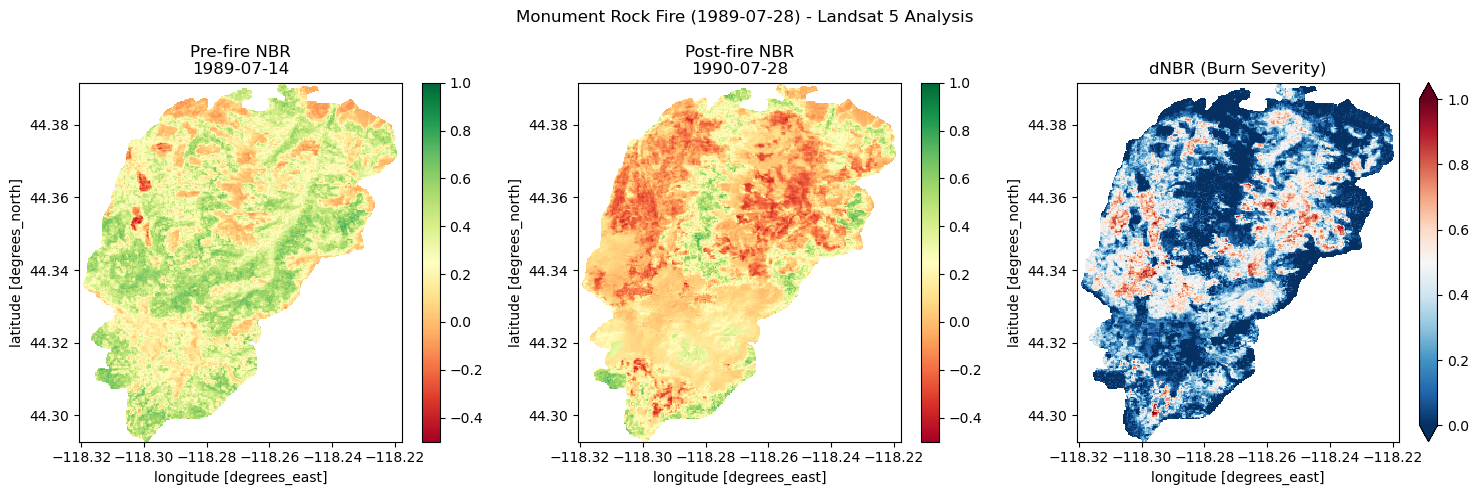

{'fire_info': {'name': 'Monument Rock',
  'id': '1989-ORWWF-000377',
  'year': 1989,
  'fire_date': Timestamp('1989-07-28 00:00:00'),
  'geometry': <POLYGON ((-118.255 44.33, -118.255 44.33, -118.255 44.33, -118.255 44.33, -...>},
 'analysis_dates': {'pre_fire': Timestamp('1989-07-14 00:00:00'),
  'post_fire': Timestamp('1990-07-28 00:00:00')},
 'severity_results': {'high_severity': np.int64(2509),
  'mod_high_severity': np.int64(10862),
  'mod_low_severity': np.int64(12517),
  'low_severity': np.int64(10476),
  'unburned': np.int64(21088),
  'total_pixels': 57452},
 'dnbr_stats': {'mean': np.float64(0.23285076323663084),
  'std': np.float64(0.24381773736011328),
  'min': np.float64(-0.46292646020154404),
  'max': np.float64(1.0808250030734778)},
 'pre_fire_nbr': <xarray.DataArray (band: 1, y: 362, x: 268)> Size: 776kB
 dask.array<getitem, shape=(1, 362, 268), dtype=float64, chunksize=(1, 362, 213), chunktype=numpy.ndarray>
 Coordinates:
   * band         (band) int64 8B 1
   * x      

In [14]:
run_fire_analysis_by_date('Monument Rock', '1989-07-28', 
                                   pre_fire_days=14, post_fire_days=365)

In [31]:
"""
Multi-Fire Severity Analysis Module

Analyzes burn severity for multiple target fires using Landsat NBR data.

Functions:
- clean_fire_year(): Convert fire year values to integers
- find_target_fire(): Find specific fire by name, ID, year, and/or location
- search_landsat5_imagery(): Search for Landsat 5 images around target date
- search_with_expanding_dates(): Search with progressively wider date ranges
- calculate_nbr(): Calculate NBR from Landsat data
- analyze_fire_severity(): Calculate burn severity statistics
- analyze_multiple_fires(): Process multiple target fires
- create_summary_table(): Generate results summary

Usage:
    results = analyze_multiple_fires(geojson_path, target_fires_list)
"""

import geopandas as gpd
import pandas as pd
import numpy as np
import rioxarray as rxr
import pystac_client
import planetary_computer as pc
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


def clean_fire_year(year_value):
    """Convert fire year to integer, handling various formats."""
    try:
        if pd.isna(year_value):
            return None
        year_str = str(year_value)
        if '-' in year_str:
            return int(year_str.split('-')[0])
        return int(float(year_str))
    except (ValueError, TypeError):
        return None


def find_target_fire(fires_gdf, target_info):
    """Find a specific fire using name, and optionally year, ID, and/or location."""
    
    # If only name is provided, search across all years
    if 'year' in target_info:
        year_fires = fires_gdf[fires_gdf['FIRE_YEAR_CLEAN'] == target_info['year']]
    else:
        year_fires = fires_gdf
    
    # Try to match by fire ID first (most reliable)
    if target_info.get('fire_id') is not None:
        id_matches = year_fires[year_fires['UNQE_FIRE_'] == target_info['fire_id']]
        if len(id_matches) > 0:
            print(f"Found {target_info['name']} by Fire ID: {target_info['fire_id']}")
            return id_matches.iloc[0]
    
    # Try to match by name
    name_matches = year_fires[
        year_fires['INCIDENT'].str.contains(target_info['name'], case=False, na=False)
    ]
    
    if len(name_matches) > 0:
        if len(name_matches) == 1:
            fire = name_matches.iloc[0]
            print(f"Found {target_info['name']} by name match ({int(fire['FIRE_YEAR_CLEAN'])})")
            return fire
        else:
            # Multiple matches - show options or pick most recent
            print(f"Found {len(name_matches)} fires matching '{target_info['name']}':")
            for i, (idx, fire) in enumerate(name_matches.iterrows()):
                year = int(fire['FIRE_YEAR_CLEAN'])
                fire_id = fire.get('UNQE_FIRE_', 'No ID')
                area = fire.geometry.area * 111 * 111 * 100  # rough hectares
                print(f"  {i}: {fire['INCIDENT']} ({year}) - {area:.1f} ha - {fire_id}")
            
            # Return the most recent one
            most_recent = name_matches.loc[name_matches['FIRE_YEAR_CLEAN'].idxmax()]
            print(f"Using most recent: {most_recent['INCIDENT']} ({int(most_recent['FIRE_YEAR_CLEAN'])})")
            return most_recent
    
    # Try to match by location if provided
    if 'approx_location' in target_info:
        target_lat, target_lon = target_info['approx_location']
        location_tolerance = 0.05  # ~5km
        
        location_matches = year_fires[
            (abs(year_fires.geometry.centroid.y - target_lat) < location_tolerance) &
            (abs(year_fires.geometry.centroid.x - target_lon) < location_tolerance)
        ]
        
        if len(location_matches) > 0:
            print(f"Found {target_info['name']} by location match")
            # If multiple matches, pick the closest one
            distances = location_matches.geometry.centroid.apply(
                lambda pt: ((pt.y - target_lat)**2 + (pt.x - target_lon)**2)**0.5
            )
            closest_idx = distances.idxmin()
            return location_matches.loc[closest_idx]
    
    print(f"Could not find {target_info['name']}")
    return None


def search_landsat5_imagery(geometry, target_date, days_buffer=30):
    """Search for Landsat 5 imagery around target date."""
    
    start_date = (target_date - timedelta(days=days_buffer)).strftime('%Y-%m-%d')
    end_date = (target_date + timedelta(days=days_buffer)).strftime('%Y-%m-%d')
    
    catalog = pystac_client.Client.open(
        "https://planetarycomputer.microsoft.com/api/stac/v1/",
        modifier=pc.sign_inplace
    )
    
    bounds = geometry.bounds
    bbox = [bounds[0], bounds[1], bounds[2], bounds[3]]
    
    search = catalog.search(
        collections=["landsat-c2-l2"],
        bbox=bbox,
        datetime=f"{start_date}/{end_date}",
        query={
            "platform": {"in": ["landsat-5"]},
            "eo:cloud_cover": {"lt": 70}
        }
    )
    
    items = list(search.items())
    
    if len(items) > 0:
        # Sort by cloud cover and date proximity
        items_with_info = []
        for item in items:
            cloud_cover = item.properties.get('eo:cloud_cover', 100)
            item_date = pd.to_datetime(item.properties['datetime'])
            
            if item_date.tz is not None:
                item_date = item_date.tz_localize(None)
            if hasattr(target_date, 'tz') and target_date.tz is not None:
                target_date = target_date.tz_localize(None)
            
            date_diff = abs((item_date - target_date).days)
            items_with_info.append((item, cloud_cover, date_diff, item_date.strftime('%Y-%m-%d')))
        
        items_with_info.sort(key=lambda x: (x[2], x[1]))
        sorted_items = [item for item, cloud, date_diff, date_str in items_with_info]
        
        print(f"    Found {len(sorted_items)} images, best: {items_with_info[0][3]} ({items_with_info[0][1]:.1f}% clouds)")
        return sorted_items
    else:
        print(f"    No Landsat 5 images found")
        return []


def search_with_expanding_dates(geometry, target_date, fire_name=""):
    """Search with progressively expanding date ranges."""
    buffers = [30, 60, 120, 240]
    
    print(f"  Searching imagery for {fire_name}...")
    for attempt, buffer in enumerate(buffers):
        if attempt > 0:
            print(f"    Attempt {attempt + 1}: +/-{buffer} days...")
        items = search_landsat5_imagery(geometry, target_date, days_buffer=buffer)
        
        if len(items) > 0:
            return items
    
    print(f"    No imagery found for {fire_name}")
    return []


def calculate_nbr(item, fire_polygon, fire_name=""):
    """Calculate NBR from Landsat 5, clipped to fire boundary."""
    try:
        signed_item = pc.sign(item)
        
        # Find correct band names
        available_assets = list(signed_item.assets.keys())
        nir_band = None
        swir2_band = None
        
        for asset in ['B04', 'nir08', 'NIR']:
            if asset in available_assets:
                nir_band = asset
                break
                
        for asset in ['B07', 'swir22', 'SWIR2']:
            if asset in available_assets:
                swir2_band = asset
                break
        
        if nir_band is None or swir2_band is None:
            print(f"    Missing bands for {fire_name}. Available: {available_assets}")
            return None
        
        # Load bands
        nir = rxr.open_rasterio(signed_item.assets[nir_band].href, chunks={'x': 1024, 'y': 1024})
        swir2 = rxr.open_rasterio(signed_item.assets[swir2_band].href, chunks={'x': 1024, 'y': 1024})
        
        # Convert fire to raster CRS and crop
        temp_gdf = gpd.GeoDataFrame([1], geometry=[fire_polygon], crs='EPSG:4326')
        fire_proj = temp_gdf.to_crs(nir.rio.crs).geometry.iloc[0]
        bounds = fire_proj.bounds
        crop_buffer = 2000
        
        try:
            nir_cropped = nir.rio.clip_box(
                minx=bounds[0] - crop_buffer, miny=bounds[1] - crop_buffer,
                maxx=bounds[2] + crop_buffer, maxy=bounds[3] + crop_buffer
            )
            swir2_cropped = swir2.rio.clip_box(
                minx=bounds[0] - crop_buffer, miny=bounds[1] - crop_buffer,
                maxx=bounds[2] + crop_buffer, maxy=bounds[3] + crop_buffer
            )
        except:
            nir_cropped = nir
            swir2_cropped = swir2
        
        # Apply Landsat Collection 2 scaling
        nir_scaled = nir_cropped * 0.0000275 - 0.2
        swir2_scaled = swir2_cropped * 0.0000275 - 0.2
        
        # Ensure same resolution
        if nir_scaled.shape != swir2_scaled.shape:
            swir2_scaled = swir2_scaled.rio.reproject_match(nir_scaled)
        
        # Calculate NBR
        nbr = (nir_scaled - swir2_scaled) / (nir_scaled + swir2_scaled)
        nbr = nbr.where((nir_scaled + swir2_scaled) != 0)
        
        # Clip to fire boundary
        nbr_fire_only = nbr.rio.clip([fire_proj], crs=nbr.rio.crs, drop=True, all_touched=True)
        
        valid_pixels = (~np.isnan(nbr_fire_only.values)).sum()
        
        if valid_pixels == 0:
            print(f"    No valid data for {fire_name}")
            return None
        
        print(f"    NBR calculated for {fire_name} ({valid_pixels} pixels)")
        return nbr_fire_only
        
    except Exception as e:
        print(f"    Error calculating NBR for {fire_name}: {e}")
        return None


def analyze_fire_severity(dnbr_values):
    """Calculate burn severity statistics from dNBR values."""
    high_severity = np.sum(dnbr_values > 0.66)
    mod_high_severity = np.sum((dnbr_values >= 0.44) & (dnbr_values <= 0.66))
    mod_low_severity = np.sum((dnbr_values >= 0.25) & (dnbr_values < 0.44))
    low_severity = np.sum((dnbr_values >= 0.1) & (dnbr_values < 0.25))
    unburned = np.sum(dnbr_values < 0.1)
    total_pixels = len(dnbr_values)
    
    return {
        'total_pixels': total_pixels,
        'dnbr_mean': np.mean(dnbr_values),
        'dnbr_std': np.std(dnbr_values),
        'dnbr_min': np.min(dnbr_values),
        'dnbr_max': np.max(dnbr_values),
        'high_severity_pct': 100 * high_severity / total_pixels,
        'mod_high_severity_pct': 100 * mod_high_severity / total_pixels,
        'mod_low_severity_pct': 100 * mod_low_severity / total_pixels,
        'low_severity_pct': 100 * low_severity / total_pixels,
        'unburned_pct': 100 * unburned / total_pixels
    }


def analyze_multiple_fires(geojson_path, target_fires):
    """Analyze burn severity for multiple target fires."""
    
    print("Loading fire data...")
    fires = gpd.read_file(geojson_path)
    
    # Clean fire year data
    fires['FIRE_YEAR_CLEAN'] = fires['FIRE_YEAR'].apply(clean_fire_year)
    fires_clean = fires.dropna(subset=['FIRE_YEAR_CLEAN'])
    fires_clean['FIRE_YEAR_CLEAN'] = fires_clean['FIRE_YEAR_CLEAN'].astype(int)
    fires_wgs84 = fires_clean.to_crs('EPSG:4326')
    
    print(f"Loaded {len(fires_wgs84)} fire records")
    
    # Find all target fires
    found_fires = []
    for target in target_fires:
        fire_row = find_target_fire(fires_wgs84, target)
        if fire_row is not None:
            fire_info = {
                'target_name': target['name'],
                'fire_row': fire_row,
                'fire_geom': fire_row.geometry,
                'fire_year': int(fire_row['FIRE_YEAR_CLEAN']),
                'incident_name': fire_row.get('INCIDENT', target['name']),
                'fire_id': fire_row.get('UNQE_FIRE_', 'No ID'),
                'area_hectares': fire_row.geometry.area * 111 * 111 * 100
            }
            found_fires.append(fire_info)
    
    print(f"Found {len(found_fires)} out of {len(target_fires)} target fires")
    
    # Analyze each fire
    results = []
    
    for i, fire in enumerate(found_fires):
        print(f"\n{i+1}. Analyzing {fire['target_name']} ({fire['fire_year']})")
        print(f"Area: {fire['area_hectares']:.1f} hectares")
        
        # Define analysis dates
        pre_fire_date = pd.to_datetime(f"{fire['fire_year']}-04-15")
        post_fire_date = pd.to_datetime(f"{fire['fire_year'] + 1}-07-01")
        
        print(f"Pre-fire: {pre_fire_date.strftime('%Y-%m-%d')}")
        print(f"Post-fire: {post_fire_date.strftime('%Y-%m-%d')}")
        
        # Search for imagery
        pre_fire_items = search_with_expanding_dates(fire['fire_geom'], pre_fire_date, 
                                                    f"{fire['target_name']} pre-fire")
        
        if len(pre_fire_items) > 0:
            post_fire_items = search_with_expanding_dates(fire['fire_geom'], post_fire_date,
                                                         f"{fire['target_name']} post-fire")
            
            if len(post_fire_items) > 0:
                # Calculate NBR
                print("  Calculating NBR...")
                pre_nbr = calculate_nbr(pre_fire_items[0], fire['fire_geom'], 
                                      f"{fire['target_name']} pre")
                post_nbr = calculate_nbr(post_fire_items[0], fire['fire_geom'],
                                       f"{fire['target_name']} post")
                
                if pre_nbr is not None and post_nbr is not None:
                    # Calculate dNBR
                    if pre_nbr.rio.crs != post_nbr.rio.crs:
                        post_nbr = post_nbr.rio.reproject_match(pre_nbr)
                    
                    dnbr = pre_nbr - post_nbr
                    
                    # Analyze burn severity
                    dnbr_computed = dnbr.compute()
                    dnbr_flat = dnbr_computed.values.flatten()
                    dnbr_flat = dnbr_flat[~np.isnan(dnbr_flat)]
                    
                    if len(dnbr_flat) > 0:
                        severity_stats = analyze_fire_severity(dnbr_flat)
                        
                        # Store results
                        fire_result = {
                            'fire_name': fire['target_name'],
                            'incident_name': fire['incident_name'],
                            'fire_year': fire['fire_year'],
                            'fire_id': fire['fire_id'],
                            'area_hectares': fire['area_hectares'],
                            **severity_stats,
                            'pre_nbr': pre_nbr,
                            'post_nbr': post_nbr,
                            'dnbr': dnbr
                        }
                        results.append(fire_result)
                        
                        print(f"  Analysis complete!")
                        print(f"    dNBR mean: {severity_stats['dnbr_mean']:.3f}")
                        print(f"    High severity: {severity_stats['high_severity_pct']:.1f}%")
                        print(f"    Pixels analyzed: {severity_stats['total_pixels']}")
                    else:
                        print(f"  No valid dNBR data")
                else:
                    print(f"  NBR calculation failed")
            else:
                print(f"  No post-fire imagery found")
        else:
            print(f"  No pre-fire imagery found")
    
    return results


def create_summary_table(results):
    """Generate a summary table of results."""
    if not results:
        return None
    
    summary_df = pd.DataFrame([
        {
            'Fire': r['fire_name'],
            'Year': r['fire_year'],
            'Area (ha)': f"{r['area_hectares']:.1f}",
            'dNBR Mean': f"{r['dnbr_mean']:.3f}",
            'High Severity %': f"{r['high_severity_pct']:.1f}",
            'Mod-High %': f"{r['mod_high_severity_pct']:.1f}",
            'Mod-Low %': f"{r['mod_low_severity_pct']:.1f}",
            'Low %': f"{r['low_severity_pct']:.1f}",
            'Unburned %': f"{r['unburned_pct']:.1f}",
            'Pixels': r['total_pixels']
        }
        for r in results
    ])
    
    return summary_df


def print_detailed_results(results):
    """Print detailed results for all analyzed fires."""
    if not results:
        print("No fires were successfully analyzed.")
        return
    
    print(f"\nDETAILED RESULTS:")
    for r in results:
        print(f"\n{r['fire_name']} ({r['fire_year']}):")
        print(f"  Incident Name: {r['incident_name']}")
        print(f"  Fire ID: {r['fire_id']}")
        print(f"  Area: {r['area_hectares']:.1f} hectares")
        print(f"  Pixels Analyzed: {r['total_pixels']}")
        print(f"  dNBR: {r['dnbr_mean']:.3f} ± {r['dnbr_std']:.3f} (range: {r['dnbr_min']:.3f} to {r['dnbr_max']:.3f})")
        print(f"  Burn Severity Distribution:")
        print(f"    High (>0.66):      {r['high_severity_pct']:5.1f}%")
        print(f"    Moderate-High:     {r['mod_high_severity_pct']:5.1f}%")
        print(f"    Moderate-Low:      {r['mod_low_severity_pct']:5.1f}%")
        print(f"    Low:               {r['low_severity_pct']:5.1f}%")
        print(f"    Unburned:          {r['unburned_pct']:5.1f}%")


def run_fire_analysis(geojson_path, target_fires):
    """Run burn severity analysis on a list of target fires."""
    
    print("MULTI-FIRE SEVERITY ANALYSIS")
    print("="*30)
    
    # Run analysis
    results = analyze_multiple_fires(geojson_path, target_fires)
    
    # Display results
    if results:
        summary_df = create_summary_table(results)
        print(f"\nSUMMARY TABLE:")
        print(summary_df.to_string(index=False))
        
        print_detailed_results(results)
        
        print(f"\nSuccessfully analyzed {len(results)} out of {len(target_fires)} target fires!")
        
    else:
        print("No fires were successfully analyzed.")
        print("This could be due to:")
        print("  - Limited Landsat 5 imagery availability for 1989-1990")
        print("  - Cloud cover issues")
        print("  - Data processing errors")
    
    print(f"\nAnalysis complete!")
    return results


if __name__ == "__main__":
    print("Multi-Fire Severity Analysis")
    print("Example Usage:")
    print("target_fires = [")
    print("    {'name': 'Big Fire'},")
    print("    {'name': 'Blaze'},")
    print("    {'name': 'Flame'}")
    print("]")
    print("results = run_fire_analysis('path/to/fires.geojson', target_fires)")
    print("\nOptional: Add 'year', 'fire_id', or 'approx_location' for better matching")

Multi-Fire Severity Analysis
Example Usage:
target_fires = [
    {'name': 'Big Fire'},
    {'name': 'Blaze'},
    {'name': 'Flame'}
]
results = run_fire_analysis('path/to/fires.geojson', target_fires)

Optional: Add 'year', 'fire_id', or 'approx_location' for better matching


In [32]:
target_fires = [
    {'name': 'Corral Basin', 'year': 1990},
    {'name': 'Sheep Mountain', 'year': 1990},
    {'name': 'Snowshoe', 'year': 1990},
    {'name': 'Glacier', 'year': 1989}  # Specify the year to get the right fire
]

results = run_fire_analysis('../downloaded_data/mnf_fires_all.geojson', target_fires)

MULTI-FIRE SEVERITY ANALYSIS
Loading fire data...
Loaded 216 fire records
Found Corral Basin by name match (1990)
Found Sheep Mountain by name match (1990)
Found Snowshoe by name match (1990)
Found Glacier by name match (1989)
Found 4 out of 4 target fires

1. Analyzing Corral Basin (1990)
Area: 637.3 hectares
Pre-fire: 1990-04-15
Post-fire: 1991-07-01
  Searching imagery for Corral Basin pre-fire...
    Found 4 images, best: 1990-04-10 (6.0% clouds)
  Searching imagery for Corral Basin post-fire...
    Found 3 images, best: 1991-07-02 (0.0% clouds)
  Calculating NBR...
    NBR calculated for Corral Basin pre (5366 pixels)
    NBR calculated for Corral Basin post (5366 pixels)
  Analysis complete!
    dNBR mean: 0.903
    High severity: 86.8%
    Pixels analyzed: 5366

2. Analyzing Sheep Mountain (1990)
Area: 6168.5 hectares
Pre-fire: 1990-04-15
Post-fire: 1991-07-01
  Searching imagery for Sheep Mountain pre-fire...
    Found 4 images, best: 1990-04-10 (6.0% clouds)
  Searching imager

SyntaxError: incomplete input (111011014.py, line 621)